In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from sklearn.datasets import fetch_20newsgroups
from datasets import Dataset, DatasetDict, ClassLabel
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
import torch

import numpy as np

In [3]:
categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]
remove=("headers", "footers", "quotes")

ng = fetch_20newsgroups(subset="all", categories=categories, 
                              shuffle=True, random_state=42, remove=remove)

X_train, X_temp, y_train, y_temp = train_test_split(ng.data, ng.target, test_size=0.3, random_state=42)
X_eval, X_test, y_eval, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

hf_dataset_dict = {'train': Dataset.from_dict({"text": X_train, "label": y_train}),
              'eval' : Dataset.from_dict({"text": X_eval, "label": y_eval}),
              'test' : Dataset.from_dict({"text": X_test, "label": y_test}),
}
ng_dataset = DatasetDict(hf_dataset_dict)
ng_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2370
    })
    eval: Dataset({
        features: ['text', 'label'],
        num_rows: 508
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 509
    })
})

In [4]:
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, model_max_length=512, padding='max_length', truncation=True)

tokenizer.model_max_length

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

512

In [5]:
def tokenize(batch):
  return tokenizer(batch['text'], padding=True, truncation=True)

ng_encoded = ng_dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/2370 [00:00<?, ? examples/s]

Map:   0%|          | 0/508 [00:00<?, ? examples/s]

Map:   0%|          | 0/509 [00:00<?, ? examples/s]

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = AutoModel.from_pretrained(model_ckpt).to(device)

cuda


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [7]:
ng_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [8]:
def extract_hidden_states(batch):
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  return {'hidden_state':last_hidden_state[:,0].cpu().numpy()}

In [9]:
ng_hidden = ng_encoded.map(extract_hidden_states, batched=True, batch_size=8)

Map:   0%|          | 0/2370 [00:00<?, ? examples/s]

Map:   0%|          | 0/508 [00:00<?, ? examples/s]

Map:   0%|          | 0/509 [00:00<?, ? examples/s]

In [10]:
X_train = np.array(ng_hidden['train']['hidden_state'])
X_eval = np.array(ng_hidden['eval']['hidden_state'])
y_train = np.array(ng_hidden['train']['label'])
y_eval = np.array(ng_hidden['eval']['label'])
X_train.shape, X_eval.shape

((2370, 768), (508, 768))

In [11]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr.score(X_eval, y_eval)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7893700787401575

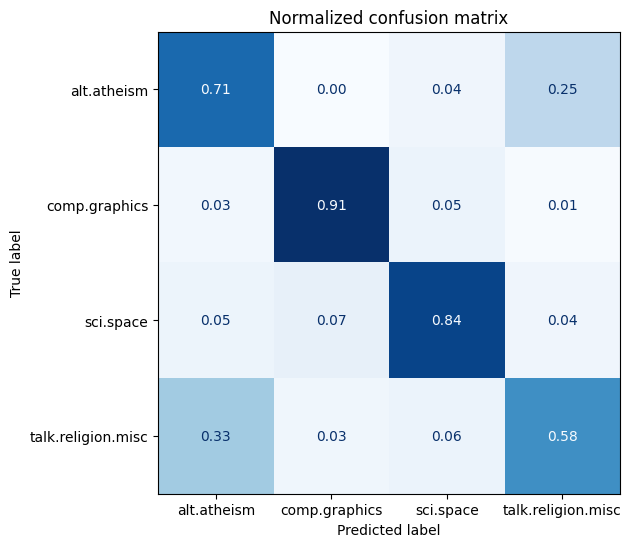

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalized confusion matrix')
    plt.show()
y_preds = lr.predict(X_eval)
plot_confusion_matrix(y_preds, y_eval, ng.target_names)

In [13]:
from transformers import AutoModelForSequenceClassification

num_labels = 4
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1=f1_score(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {'accuracy':acc, 'f1':f1}

In [22]:
from transformers import Trainer, TrainingArguments

batch_size = 16
logging_steps = len(ng_encoded['train'])
model_name = f"{model_ckpt}-finetuned-20ng"
training_args = TrainingArguments(output_dir=model_name, num_train_epochs=5,
                                 learning_rate=2e-5,
                                 per_device_train_batch_size=batch_size,
                                 per_device_eval_batch_size=batch_size,
                                 weight_decay=0.001,
                                 evaluation_strategy='epoch',
                                 disable_tqdm=False,
                                 log_level='error', report_to='none',
                                 )

In [23]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metrics, 
                 train_dataset=ng_encoded['train'],
                 eval_dataset=ng_encoded['eval'], tokenizer=tokenizer)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [24]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.542796,0.777559,0.723847
2,No log,0.469633,0.797244,0.769462
3,No log,0.452100,0.812992,0.785442
4,No log,0.444178,0.826772,0.799347
5,No log,0.439928,0.834646,0.809727


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=375, training_loss=0.46456986490885416, metrics={'train_runtime': 335.1318, 'train_samples_per_second': 35.359, 'train_steps_per_second': 1.119, 'total_flos': 1569794662195200.0, 'train_loss': 0.46456986490885416, 'epoch': 5.0})

In [25]:
preds_output = trainer.predict(ng_encoded['eval'])

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [26]:
preds_output.metrics

{'test_loss': 0.4399277865886688,
 'test_accuracy': 0.8346456692913385,
 'test_f1': 0.8097266580796547,
 'test_runtime': 4.7368,
 'test_samples_per_second': 107.246,
 'test_steps_per_second': 3.378}

In [27]:
y_preds = np.argmax(preds_output.predictions, axis=1)

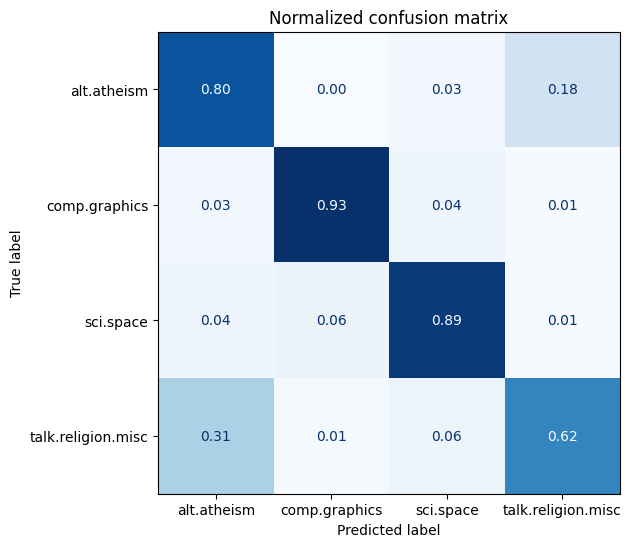

In [28]:
plot_confusion_matrix(y_preds, y_eval, ng.target_names)